# NLP-Text_Mining-Classification

## Bag of words

### CountVectorizer

In [1]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
corpus = [
     'The car is driven on the road',
     'The truck is driven on the highway',     
 ]

## N-grams
#### Bi-grams

In [3]:
vectorizer = CountVectorizer(ngram_range=(2,2))
X = vectorizer.fit_transform(corpus)
print(X.toarray())

[[1 1 1 1 1 0 1 0 0]
 [0 1 1 1 0 1 0 1 1]]


In [4]:
vocab = vectorizer.vocabulary_
vocab

{'the car': 4,
 'car is': 0,
 'is driven': 2,
 'driven on': 1,
 'on the': 3,
 'the road': 6,
 'the truck': 7,
 'truck is': 8,
 'the highway': 5}

#### Uni-grams

In [5]:
vectorizer = CountVectorizer(ngram_range=(1,1))
X = vectorizer.fit_transform(corpus)
print(X.toarray())

[[1 1 0 1 1 1 2 0]
 [0 1 1 1 1 0 2 1]]


In [6]:
vocab = vectorizer.vocabulary_
vocab

{'the': 6,
 'car': 0,
 'is': 3,
 'driven': 1,
 'on': 4,
 'road': 5,
 'truck': 7,
 'highway': 2}

## TF-IDF

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()

tfidf = vectorizer.fit_transform(corpus) 
pd.DataFrame(tfidf.toarray())
#vectorizer.vocabulary_

,0,1,2,3,4,5,6,7
0,0.424717,0.30219,0.000000,0.30219,0.30219,0.424717,0.60438,0.000000
1,0.000000,0.30219,0.424717,0.30219,0.30219,0.000000,0.60438,0.424717


## Log(IDF)

In [8]:
vectorizer = TfidfVectorizer()
model = vectorizer.fit(corpus) 
dictionary = dict( zip( model.get_feature_names(), list(np.log(model.idf_))))
for sent in corpus:
    for word in sent.split(): 
        tf_idf = dictionary[word.lower()]*(sent.count(word)/len(sent.split()))
        print(word+" ----> " +str(tf_idf))

The ----> 0.0
car ----> 0.04862404082917019
is ----> 0.0
driven ----> 0.0
on ----> 0.0
the ----> 0.0
road ----> 0.04862404082917019
The ----> 0.0
truck ----> 0.04862404082917019
is ----> 0.0
driven ----> 0.0
on ----> 0.0
the ----> 0.0
highway ----> 0.04862404082917019


# Simple Classifier

In [9]:
# Perform imports and load the dataset
df = pd.read_csv('smsspamcollection.tsv', sep='\t')
df.head()

,label,message,length,punct
0,ham,"Go until jurong point, crazy.. Available only ...",111,9
1,ham,Ok lar... Joking wif u oni...,29,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,6
3,ham,U dun say so early hor... U c already then say...,49,6
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,2


### Check for missing values:

In [10]:
df.isnull().sum()

label      0
message    0
length     0
punct      0
dtype: int64

In [11]:
df['label'].value_counts()

ham     4825
spam     747
Name: label, dtype: int64

### Split the data into train & test sets:

In [12]:
from sklearn.model_selection import train_test_split
X = df['message']  # this time we want to look at the text
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

In [14]:
X_train_counts

<3733x7082 sparse matrix of type '<class 'numpy.int64'>'
	with 49992 stored elements in Compressed Sparse Row format>

In [15]:
X_train_counts.shape

(3733, 7082)

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()

X_train_tfidf = vectorizer.fit_transform(X_train) # remember to use the original X_train set
X_train_tfidf.shape

(3733, 7082)

In [17]:
X_train_tfidf

<3733x7082 sparse matrix of type '<class 'numpy.float64'>'
	with 49992 stored elements in Compressed Sparse Row format>

## Train a Classifier
## Model 1 - Linear SVC

In [18]:
from sklearn.svm import LinearSVC
clf = LinearSVC()
clf.fit(X_train_tfidf,y_train)

LinearSVC()

In [19]:
# Form a prediction set
predictions = clf.predict(X_train_tfidf)
predictions

array(['ham', 'ham', 'ham', ..., 'ham', 'ham', 'ham'], dtype=object)

## Build a Pipeline

In [20]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC

text_clf = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', LinearSVC()),
])

# Feed the training data through the pipeline
text_clf.fit(X_train, y_train) 

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', LinearSVC())])

## Test the classifier and display results

In [21]:
# Form a prediction set
predictions = text_clf.predict(X_test)

In [22]:
# Report the confusion matrix
from sklearn import metrics
print(metrics.confusion_matrix(y_test,predictions))

[[1586    7]
 [  12  234]]


In [23]:
# Print a classification report
print(metrics.classification_report(y_test,predictions))

              precision    recall  f1-score   support

         ham       0.99      1.00      0.99      1593
        spam       0.97      0.95      0.96       246

    accuracy                           0.99      1839
   macro avg       0.98      0.97      0.98      1839
weighted avg       0.99      0.99      0.99      1839



In [24]:
# Print the overall accuracy
print(metrics.accuracy_score(y_test,predictions))

0.989668297988037


## Model 2 Naive Bayes

In [25]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.svm import LinearSVC
text_clf = Pipeline([('tfidf', TfidfVectorizer()),
                     ('mnb', MultinomialNB()),
])
# Feed the training data through the pipeline
text_clf.fit(X_train, y_train)  

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('mnb', MultinomialNB())])

## Test the classifier and display results

In [26]:
# Form a prediction set
predictions = text_clf.predict(X_test)

In [27]:
# Print the overall accuracy
print(metrics.accuracy_score(y_test, predictions))

0.9619358346927678


In [28]:
# Report the confusion matrix
from sklearn import metrics
print(metrics.confusion_matrix(y_test,predictions))

[[1593    0]
 [  70  176]]


## Model 3 RandomForestClassifier

In [29]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
text_clf = Pipeline([('tfidf', TfidfVectorizer()),
                     ('mnb', RandomForestClassifier(n_estimators=100)),
])
# Feed the training data through the pipeline
text_clf.fit(X_train, y_train)  

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('mnb', RandomForestClassifier())])

## Test the classifier and display results

In [30]:
# Form a prediction set
predictions = text_clf.predict(X_test)

In [31]:
# Print the overall accuracy
print(metrics.accuracy_score(y_test, predictions))

0.9793365959760739


In [32]:
# Report the confusion matrix
from sklearn import metrics
print(metrics.confusion_matrix(y_test,predictions))

[[1593    0]
 [  38  208]]


## Word Cloud

In [33]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import numpy as np

In [34]:
# Returns a string
dataset = open("modi.txt", "r").read()
dataset = dataset.lower()

In [35]:
maskArray = np.array(Image.open("modi.png"))
cloud = WordCloud(background_color = "white", max_words = 200, mask = maskArray, stopwords = set(STOPWORDS))

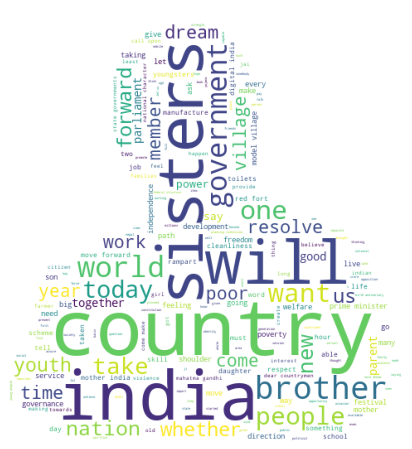

In [36]:
#cloud = WordCloud(background_color = "black", max_words = 100,  stopwords = set(STOPWORDS))
cloud.generate(dataset)
plt.figure(figsize=(14,8))
#cloud.to_file("wordCloud.png")
plt.axis("off")
plt.imshow(cloud)
plt.show()